In [296]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Obtain training and validation data

In [297]:
image_size = (72, 72)
input_shape = (72, 72, 3)

# Use image_dataset_from_directory to easily acquire images and their labels.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/spots',
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=image_size,
    batch_size=1,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/spots',
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=image_size,
    batch_size=1,
    label_mode='categorical'
)

Found 818 files belonging to 3 classes.
Using 655 files for training.
Found 818 files belonging to 3 classes.
Using 163 files for validation.


# Convert from TensorFlow Dataset to numpy for easy manipulation

In [298]:
# Training data
X_train, y_train = [], []
for image, label in train_ds:
    X_train.append(image)
    y_train.append(np.array(label))
X_train = np.array(X_train, dtype=np.uint8)
X_train = X_train.reshape((X_train.shape[0],) + input_shape)
y_train = np.array(y_train)
y_train = y_train.reshape((y_train.shape[0],) + (y_train.shape[-1],))

# Validation data
X_val, y_val = [], []
for image, label in val_ds:
    X_val.append(image)
    y_val.append(np.array(label))
X_val = np.array(X_val, dtype=np.uint8)
X_val= X_val.reshape((X_val.shape[0],) + input_shape)
y_val = np.array(y_val)
y_val = y_val.reshape((y_val.shape[0],) + (y_val.shape[-1],))

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (655, 72, 72, 3)
y_train shape: (655, 3)
X_val shape: (163, 72, 72, 3)
y_val shape: (163, 3)


# Show sample images from training data

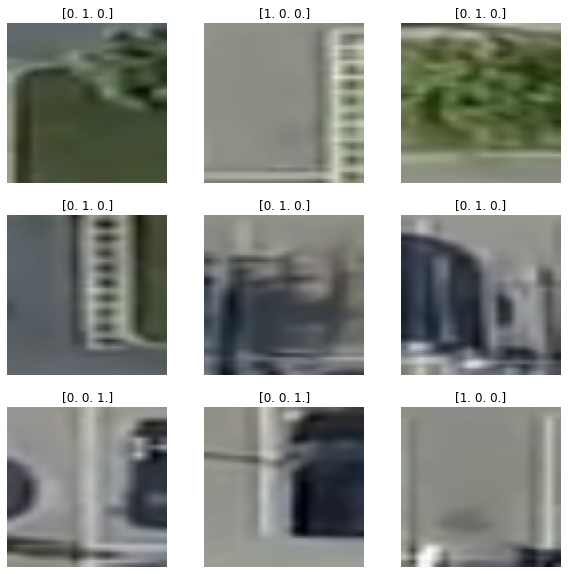

In [309]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for image, label, ax in zip(X_train, y_train, axes.flatten()):
    ax.imshow(image)
    ax.set_title(label)
    ax.set_axis_off()
plt.savefig('images/sample_training_data.png')

# Augment the training data

Not used here because we are relying on pre-trained network to extract features for us.

In [300]:
# # Augment the images by applying random horizontal flip and rotation.
# # This is a sequence of layers that can be applied to the input data.
# data_augmentation = keras.Sequential(
#     [
#         layers.experimental.preprocessing.RandomFlip('horizontal'),
#         layers.experimental.preprocessing.RandomRotation(0.1),  # 0-10% clockwise or counter-clockwise rotation
#         layers.experimental.preprocessing.Rescaling(1.0 / 255),
#     ]
# )

# # Demo the effect of augmentation
# fig, axes = plt.subplots(3, 3, figsize=(10, 10))
# for i, ax in enumerate(axes.flatten()):
#     augmented = np.array(data_augmentation(X_train))
#     ax.imshow(augmented[0])
#     ax.set_title(y_train[0])
#     ax.set_axis_off()

In [301]:
def load_pretrained_models(input_shape):
    """Load all the pre-trained models that we want to try.

    We can add any pre-trained models provided by keras here. We return
    a dict that contains the model itself and the `preprocess_input`
    function associated with each model.

    :param input_shape: Shape of the input image.
    :return: A dict containing each pre-trained model and its pre-process
        function.
    """
    all_models = {
        'xception': {
            'model': keras.applications.Xception(include_top=False, input_shape=input_shape),
            'preprocess': keras.applications.xception.preprocess_input,
        },
        'vgg16': {
            'model': keras.applications.VGG16(include_top=False, input_shape=input_shape),
            'preprocess': keras.applications.vgg16.preprocess_input,
        },
        'resnet50': {
            'model': keras.applications.ResNet50(include_top=False, input_shape=input_shape),
            'preprocess': keras.applications.resnet.preprocess_input,
        },
    }
    return all_models


all_models = load_pretrained_models(input_shape)

In [302]:
def make_model(input_shape, num_classes):
    """Make our own model.

    Note that since we are using a pre-trained model to extract features
    for us, the input is no longer the image itself, but the extracted
    feature from the pre-trained model. The model itself is very simple.
    Since the features have been extracted alredy, we only need to attach
    a flatten and dense layer to complete the network.

    :param input_shape: The shape of the OUTPUT of the pre-trained model.
    :param num_classes: The number of classes to predict.
    :return: The instance of our own model
    """
    inputs = keras.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    outputs = layers.Dense(
        num_classes,
        activation='softmax' if num_classes > 1 else 'sigmoid',
    )(x)

    model = keras.Model(inputs, outputs)
    return model

In [303]:
def fit_model(all_models, model_name, X_train, y_train, X_val, y_val, num_classes=3, batch_size=32):
    """The one-stop shop to fit the model.

    It goes from pre-processing the data, extract features from the data using a pre-trained
    model, feed the extracted features to our own model, fit the model, and obtain results.

    :param all_models: A dict containing all the models and their pre-processing functions.
    :param model_name: Name of the model. Available names are the keys of `all_models`.
    :param X_train: training images, as a numpy array of shape (n, width, height, channel),
        where n is the number of training images.
    :param y_train: Training labels, as a numpy array of shape (n, k), where n is the number
        of training images and k the number of classes to predict (same as `num_classes`).
        Note that the labels are one-hot encoded.
    :param X_val: validation images, as a numpy array of shape (m, width, height, channel),
        where m is the number of validation images.
    :param y_val: validation labels, as a numpy array of shape (m, k), where m is the number
        of validation images. The meaning of k is the same as described in `y_train`.
    :param num_classes: Number of classes to predict. Default to 3.
    :param batch_size: Default to 32.
    """
    premodel = all_models[model_name]['model']
    preprocess = all_models[model_name]['preprocess']
    # use the output shape of the premodel as the input shape of our own model
    model = make_model(premodel.output.shape[1:], num_classes)
    # Create new training data
    X_train_pretrained = premodel.predict(preprocess(X_train))
    train_ds_pretrained = tf.data.Dataset.from_tensor_slices(
        (X_train_pretrained, y_train),
    ).batch(batch_size)
    # Create new validation data
    X_val_pretrained = premodel.predict(preprocess(X_val))
    val_ds_pretrained = tf.data.Dataset.from_tensor_slices(
        (X_val_pretrained, y_val),
    ).batch(batch_size)
    # fit model
    epochs = 50
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    history = model.fit(
        train_ds_pretrained,
        epochs=epochs,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=10, verbose=1, mode='auto')
        ],
        validation_data=val_ds_pretrained,
    )
    return model, history




In [334]:
def plot_loss_acc(history, file_name=''):
    """Plot the loss and accuracy of a model fitting process.

    :param history: Returned history from model fitting. It must be a dict that
        contains the keys for 'loss', 'accuracy', 'val_loss', and 'val_accuracy'.
    :param file_name: file name (and path) to save the figure.
    """
    SMALL_SIZE = 10
    MEDIUM_SIZE = 20
    LARGE_SIZE = 30

    # plt.rc('font', size=LARGE_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=LARGE_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    epochs = np.arange(1, len(history['loss']) + 1)
    
    ax1.plot(epochs, history['loss'], label='Train')
    ax1.plot(epochs, history['val_loss'], label='Validate')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('(A) Model Loss Across Epochs')
    ax1.legend(loc="upper right")

    ax2.plot(epochs, history['accuracy'], label='Train')
    ax2.plot(epochs, history['val_accuracy'], label='Validate')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('(B) Model Accuracy Across Epochs')
    ax2.legend(loc="upper left")
    plt.tight_layout()
    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

In [304]:
model_xception, history_xception = fit_model(all_models, 'xception', X_train, y_train, X_val, y_val)

Epoch 1/50
21/21 [==============================] - 2s 11ms/step - loss: 1.7344 - accuracy: 0.5769 - val_loss: 0.9223 - val_accuracy: 0.7975
Epoch 2/50
21/21 [==============================] - 0s 6ms/step - loss: 0.3540 - accuracy: 0.9057 - val_loss: 1.0419 - val_accuracy: 0.7853
Epoch 3/50
21/21 [==============================] - 0s 6ms/step - loss: 0.3463 - accuracy: 0.9037 - val_loss: 0.9420 - val_accuracy: 0.7853
Epoch 4/50
21/21 [==============================] - 0s 6ms/step - loss: 0.2393 - accuracy: 0.9344 - val_loss: 0.6641 - val_accuracy: 0.8528
Epoch 5/50
21/21 [==============================] - 0s 6ms/step - loss: 0.2040 - accuracy: 0.9337 - val_loss: 0.6002 - val_accuracy: 0.8528
Epoch 6/50
21/21 [==============================] - 0s 6ms/step - loss: 0.2447 - accuracy: 0.9269 - val_loss: 0.5838 - val_accuracy: 0.8712
Epoch 7/50
21/21 [==============================] - 0s 6ms/step - loss: 0.2939 - accuracy: 0.9211 - val_loss: 1.2712 - val_accuracy: 0.8221
Epoch 8/50
21/21 [=

In [305]:
model_vgg16, history_vgg16 = fit_model(all_models, 'vgg16', X_train, y_train, X_val, y_val)

Epoch 1/50
21/21 [==============================] - 1s 13ms/step - loss: 5.3574 - accuracy: 0.4351 - val_loss: 1.1971 - val_accuracy: 0.8160
Epoch 2/50
21/21 [==============================] - 0s 4ms/step - loss: 0.8389 - accuracy: 0.8338 - val_loss: 0.8001 - val_accuracy: 0.8773
Epoch 3/50
21/21 [==============================] - 0s 4ms/step - loss: 0.3453 - accuracy: 0.9085 - val_loss: 0.7373 - val_accuracy: 0.8712
Epoch 4/50
21/21 [==============================] - 0s 4ms/step - loss: 0.1616 - accuracy: 0.9633 - val_loss: 0.7788 - val_accuracy: 0.8773
Epoch 5/50
21/21 [==============================] - 0s 4ms/step - loss: 0.0392 - accuracy: 0.9881 - val_loss: 0.7327 - val_accuracy: 0.8834
Epoch 6/50
21/21 [==============================] - 0s 5ms/step - loss: 0.0193 - accuracy: 0.9905 - val_loss: 0.7292 - val_accuracy: 0.8896
Epoch 7/50
21/21 [==============================] - 0s 4ms/step - loss: 0.0102 - accuracy: 0.9977 - val_loss: 0.7347 - val_accuracy: 0.8834
Epoch 8/50
21/21 [=

In [306]:
model_resnet50, history_resnet50 = fit_model(all_models, 'resnet50', X_train, y_train, X_val, y_val)

Epoch 1/50
21/21 [==============================] - 1s 17ms/step - loss: 1.6039 - accuracy: 0.6689 - val_loss: 0.3974 - val_accuracy: 0.9080
Epoch 2/50
21/21 [==============================] - 0s 8ms/step - loss: 0.1026 - accuracy: 0.9726 - val_loss: 0.2969 - val_accuracy: 0.9325
Epoch 3/50
21/21 [==============================] - 0s 8ms/step - loss: 0.0121 - accuracy: 0.9973 - val_loss: 0.3744 - val_accuracy: 0.9325
Epoch 4/50
21/21 [==============================] - 0s 8ms/step - loss: 0.0140 - accuracy: 0.9908 - val_loss: 0.3136 - val_accuracy: 0.9080
Epoch 5/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0173 - accuracy: 0.9925 - val_loss: 0.3512 - val_accuracy: 0.9387
Epoch 6/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3011 - val_accuracy: 0.9387
Epoch 7/50
21/21 [==============================] - 0s 7ms/step - loss: 2.1156e-04 - accuracy: 1.0000 - val_loss: 0.2920 - val_accuracy: 0.9387
Epoch 8/50
21/2

# Save the model pre-trained by ResNet50

In [308]:
model_resnet50.save('spot_parked_detection_model')

INFO:tensorflow:Assets written to: spot_parked_detection_model/assets


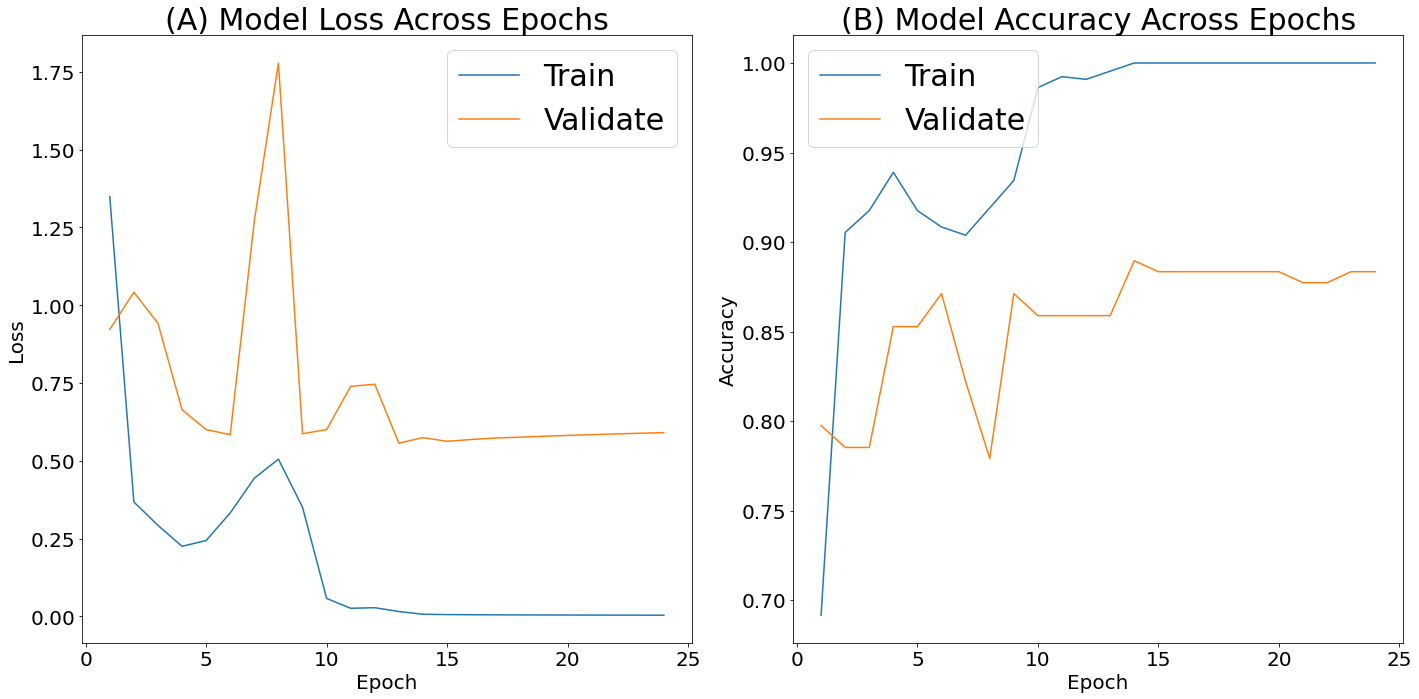

In [335]:
plot_loss_acc(history_xception.history, 'images/xception_loss_acc.png')

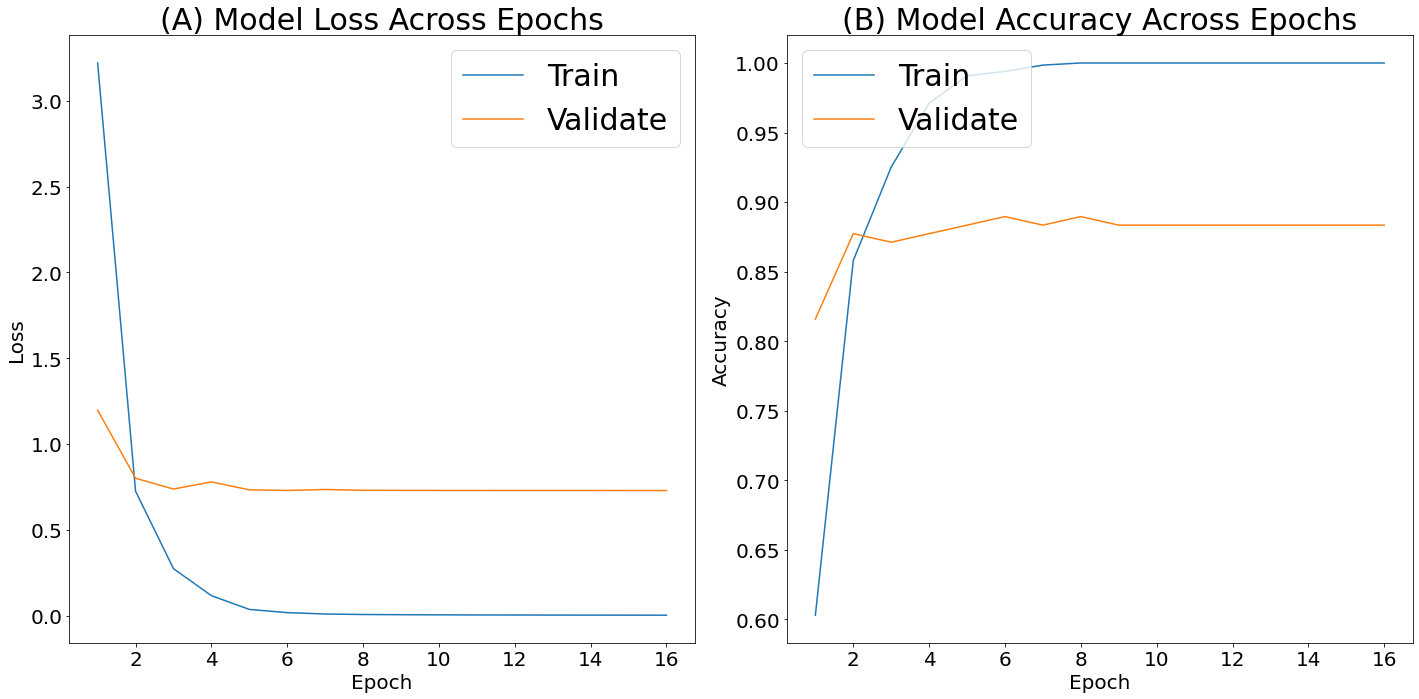

In [336]:
plot_loss_acc(history_vgg16.history, 'images/vgg16_loss_acc.png')

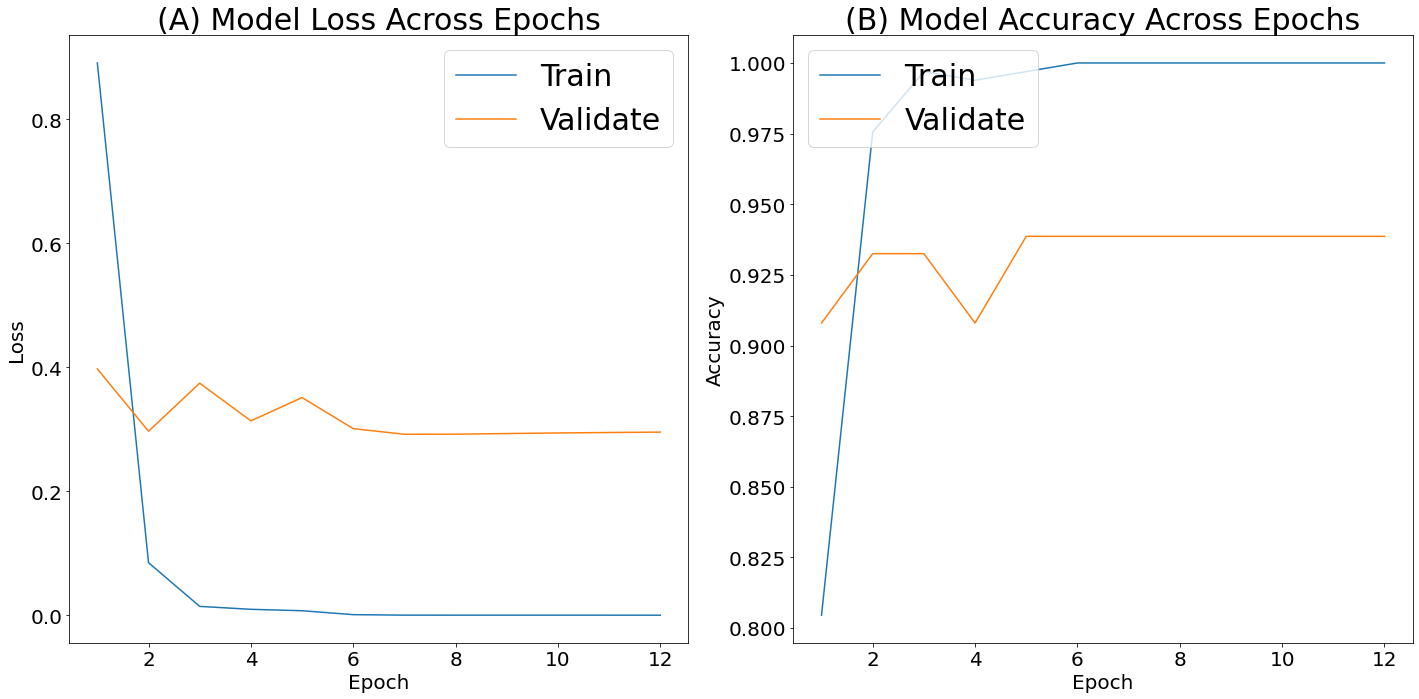

In [337]:
plot_loss_acc(history_resnet50.history, 'images/resnet50_loss_acc.png')